# Credits: 

# BE/Bi 103, Fall 2018: Homework 9
## Due 1pm, December 11

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw9.ipynb).*

<br />

## Problem 9.1: Caulobacter growth: exponential or linear, 80 pts

Remind yourself about [Homework 4.2](../hw4.html#Problem-4.2:-Caulobacter-growth,-60-pts), in which you computed the growth and division events of *Caulobacter crescentus* over time using date from [this paper](https://doi.org/10.1073/pnas.1403232111). In this problem, you will use your results from the image processing of those data sets to perform parameter estimation of the growth rates of the individual mother cells and also determine if bacterial growth on a single cell level is linear or exponential. You should use your own results form homework 4 for this problem, but in the event that you had trouble getting those results, you can use [these results](../data/hw_4.2_caulobacter_growth_image_processing_results.csv) from the HW4 solutions.

We know that under ideal conditions, bacterial cells experience exponential growth in bulk. That is, the number of cells grows exponentially. This is possible regardless of how individual cells growth; the repeated divisions lead to exponential growth. In their paper, the authors argue that the growth rate of *each* cell is also exponential.  I.e.,

\begin{align}
a(t) = a_0 \mathrm{e}^{k t},
\end{align}

where $a(t)$ is the area of the cell in the image as a function of time and $a_0$ is the area of the cell right after a division has been completed, which we mark as $t = 0$.

As an alternative model, the authors consider a linear growth model, in which

\begin{align}
a(t) = a_0 + b t.
\end{align}

An exponential curve is approximately linear (with $b = a_0k$) for short time scales.  So, it is often difficult to distinguish between a linear and an exponential growth. Your goal is to perform parameter estimates and do an effective comparison between these two models for growth. You should use hierarchical models, and be sure to take a principled approach in your model construction and evaluation.

Since you are using a hierarchical model, here are a few tips for building and implementing the models. You do not need to take this advice if you do not want to, but I have found that these strategies help.

1. Think carefully about your hyperpriors. If you choose an uninformative hyperprior for a level of the model that is data poor, you end up underpooling. For example, in this problem, there are only two mother cells. So, there are only two *Caulobacter* samples in your data set. If you put a broad prior on the growth rate of *Caulobacter* cells, these two cells can be effectively decoupled.
2. The hierarchical structure can make things difficult to code up and make it harder to hunt down bugs. As I'm building my hierarchical model, often approach it with "baby steps." I like to start off with a non-hierarchical model, often with a subset of the data. I perform sampling on this simpler model, taking a small number of samples so I do not have to wait for too long. After making sure everything is ok with this simpler structure, I then add a level to the hierarchy. I again do the sampling with a subset of the data, make sure everything works ok, and then add the next level of hierarchy, and so on. I find this helps me find bugs and little details along the way.
3. You will probably encounter the funnel of hell, so you should strongly consider using noncentered parametrizations.
4. When you sample out of the full hierarchical model, the sampler may be slower than you are used to seeing. It will likely also be much slower than sampling out of the non-hierarchical model, even though there are only a few more parameters. Stan may also be particularly slow during the warmup phase. You may see it progress taking a few seconds per iteration. This is natural.
5. Finally, just to give you a sense of what kind of computation time you might expect, for my hierarchical model, it took many hours to do the sampling on a c5.xlarge instance on AWS.


In [1]:
import numpy as np
import pandas as pd
import pystan

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
bokeh.io.output_notebook()

/home/ec2-user/miniconda/lib/python3.7/site-packages/bebi103/viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


Loading BokehJS ...

# Data Wrangling

Let's load up the datasets from 4.2 and check their structure. 

In [2]:
# Data for bacteria 1
df_bac1 = pd.read_csv("./bac_1_areas.csv")
df_bac1 = df_bac1.drop(["Unnamed: 0"], axis = 1)

# Data for bacteria 2
df_bac2 = pd.read_csv("./bac_2_areas.csv")
df_bac2 = df_bac2.drop(["Unnamed: 0"], axis = 1)
df_bac1.head()

,label,area (sq µm)
0,0,976
1,1,552
2,2,551
3,3,568
4,4,554


We graph the area over time to get a sense of it.

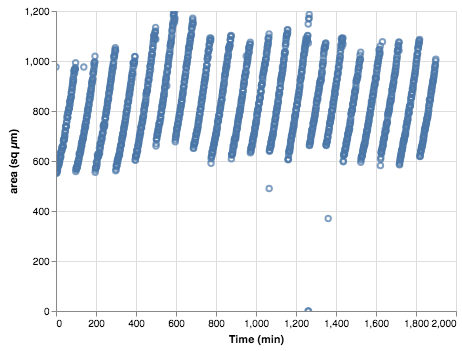

In [3]:
alt.Chart(df_bac1).mark_point().encode(
    x=alt.X('label', title = "Time (min)"),
    y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
).interactive()

And now for bacteria 2:

In [4]:
df_bac2.head()

,label,area (sq µm)
0,0,1046
1,1,435
2,2,606
3,3,610
4,4,632


And graph:

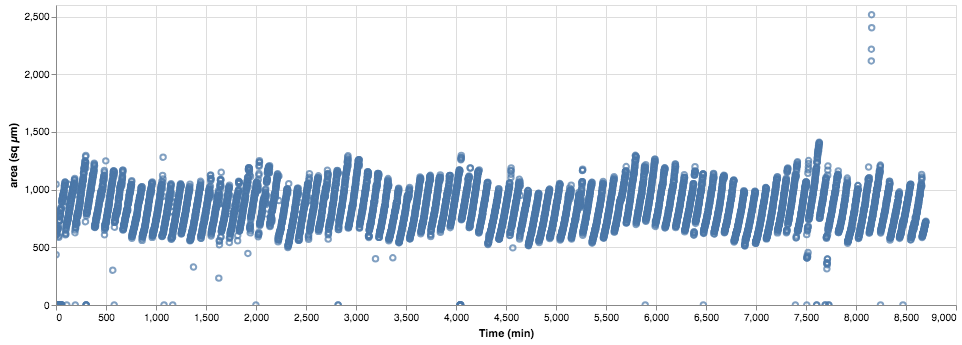

In [5]:
alt.Chart(df_bac2).mark_point().encode(
    x=alt.X('label', title = "Time (min)"),
    y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
).interactive().properties(height=300,
                           width=900)

Remove unphysical outliers:

In [6]:
df_bac1["isOutlier"] = ((df_bac1['area (sq µm)'] < 500) | # Drop low-area outliers
                        (df_bac1['area (sq µm)'] > 1500)) # Drop high-area outliers

df_bac2["isOutlier"] = ((df_bac2['area (sq µm)'] < 500) | # Drop low-area outliers
                        (df_bac2['area (sq µm)'] > 1500)) # Drop high-area outliers

bac1_thresh = df_bac1[df_bac1["isOutlier"] == False]
bac2_thresh = df_bac2[df_bac2["isOutlier"] == False]
bac1_thresh = bac1_thresh.drop(columns = ["isOutlier"])
bac2_thresh = bac2_thresh.drop(columns = ["isOutlier"])

Importing functions from 4.2

In [7]:
def find_divisions(df):
    """Returns an array that contains whether each point in a dataframe is a division or not."""
    # I will start by identifying the first division. 
    # We can see from the plots that this occurs in the first 30 frames. 
    areas = df['area (sq µm)'].values
    isDivision = np.zeros(len(df.index), dtype = bool)
    div_1 = np.argmin(areas[:30])
    isDivision[div_1] = True
    for i in range(30, len(df.index) - 30):
        region = np.zeros(61)
        for j in range(0, 61):
            region[j] = areas[i - 30 + j] # samples the 10 points on either 
                                         # side of the point of interest.
        if ((np.argmin(region) == 30) and region[30] < 780):
            isDivision[i] = True
    return isDivision

Create "isDivision" columns:

In [8]:
bac1_thresh.loc[:,"isDivision"] = find_divisions(bac1_thresh.copy())
bac2_thresh.loc[:,"isDivision"] = find_divisions(bac2_thresh.copy())

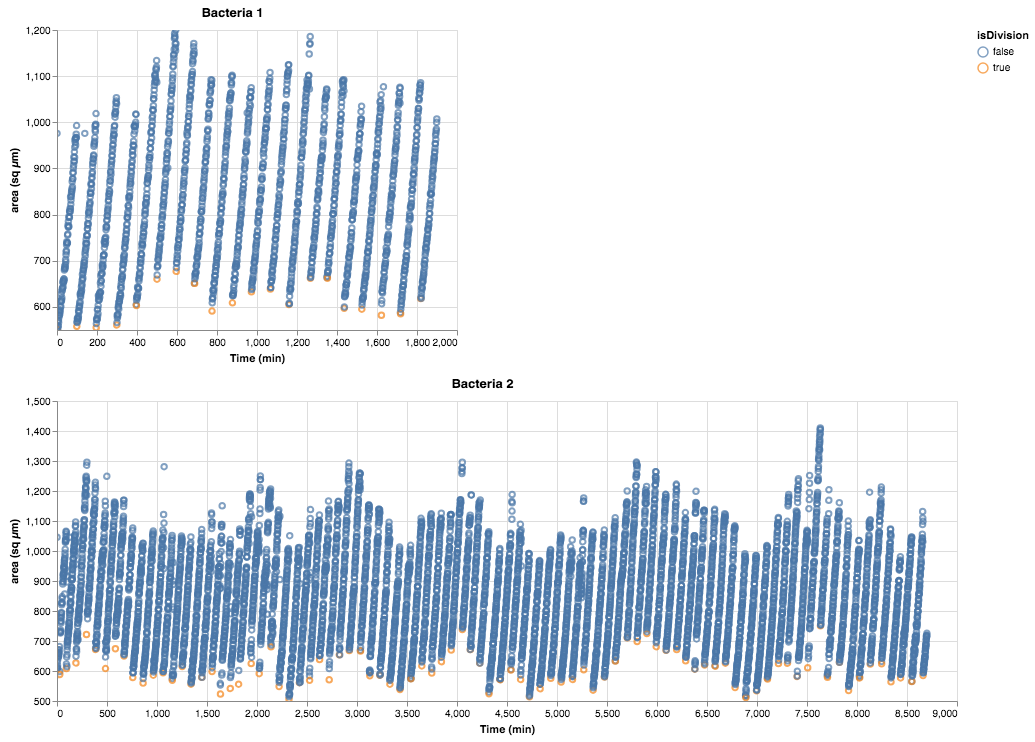

In [9]:
plot1 = alt.Chart(bac1_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = 'isDivision:N',
        ).interactive().properties(title = "Bacteria 1")

plot2 = alt.Chart(bac2_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = 'isDivision:N',
        ).interactive().properties(height=300,
                                   width=900,
                                   title = "Bacteria 2")

plot1 & plot2

I am curious how clean this data really is. I will try to color code the plot based on division number. 

In [10]:
def get_div_num(df):
    is_div = df["isDivision"].values
    div_num = np.zeros(len(is_div))
    for i in range(0, len(is_div)):
        div_num[i] = np.sum(is_div[:i + 1])
    return div_num
bac1_thresh.loc[:,"div_num"] = get_div_num(bac1_thresh.copy())
bac2_thresh.loc[:,"div_num"] = get_div_num(bac2_thresh.copy())

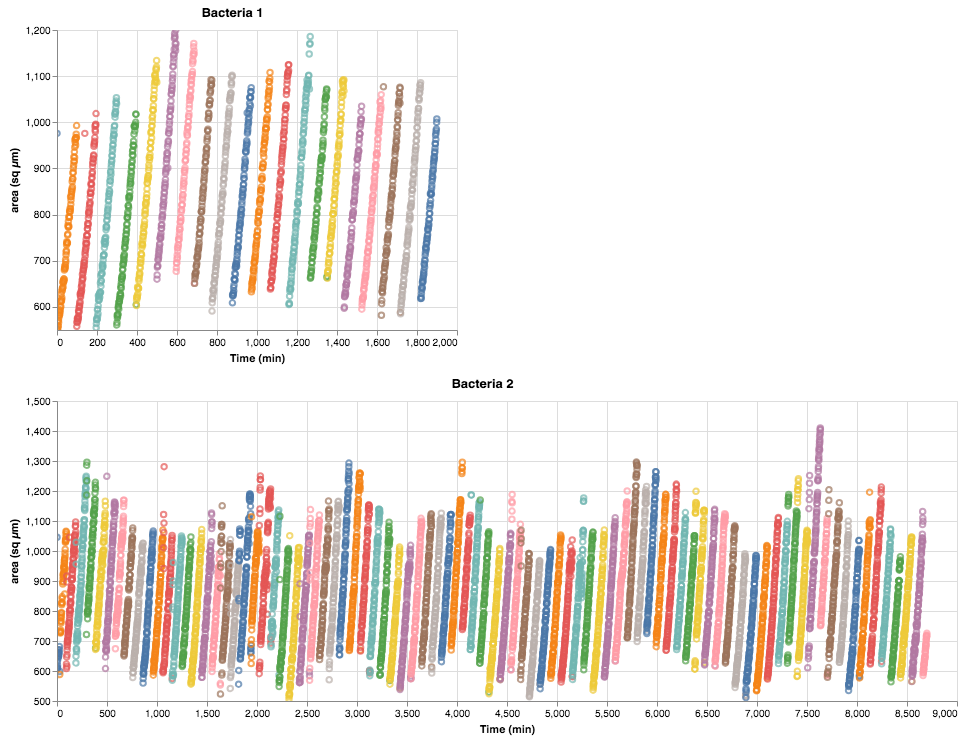

In [11]:
plot1 = alt.Chart(bac1_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
        ).interactive().properties(title = "Bacteria 1")

plot2 = alt.Chart(bac2_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
        ).interactive().properties(height=300,
                                   width=900,
                                   title = "Bacteria 2")
plot1 & plot2

The first bacterium's lineages look beautiful, but the first lineage is only two points, so I'll delete it. The first two lineages for the second bacteria look like one lineage; I'll trim some points off it and merge the lineages. 

In [12]:
# Remove lineage one for bac 1
bac1_thresh.loc[:,"div_num"] = bac1_thresh.copy()["div_num"].values - 1
bac1_thresh = bac1_thresh[bac1_thresh["div_num"] >= 0]

# Merge lineage and trim for bac 2
bac2_thresh = bac2_thresh[1:]
div_num = bac2_thresh["div_num"].values
for i in range(0, len(div_num)):
    if div_num[i] == 0:
        div_num[i] = 1
div_num = div_num - 1
bac2_thresh.loc[:,"div_num"] = div_num

/home/ec2-user/miniconda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The second bacterium's growth also looks good, with some errors near the cell divisions. We know we got the start correct, so this noise is probably because the image processing has trouble differentiating whether the cell has actually divided in the region about the division. These errors all occur above 950, so I'll just set any point near (but past) a division that is above that threshold to belong to the previous lineage. Furthermore, there are similar errors near the beginnings of divisions. If a point is in the last ten points in a lineage and is below 700, it should be in the next lineage. 

In [13]:
is_div = bac2_thresh["isDivision"].values
div_num = bac2_thresh["div_num"].values
areas = bac2_thresh['area (sq µm)'].values
for i in range(0, len(bac2_thresh.index)):
    if is_div[i] == True:
        for j in range(0, 30):
            if areas[j + i] > 950:
                div_num[j + i] = div_num[j + i] - 1
        if div_num[i] > 1:
            for j in range(-10, 0):
                if areas[j + i] < 700:
                    div_num[j + i] = div_num[j + i] + 1
bac2_thresh.loc[:,"div_num"] = div_num

We noticed a few glaring errors and removed them. 

In [14]:
# Manually delete errors in image segmentation
bac1_thresh = bac1_thresh.drop([139, 1632])

Let's re-make the plot and see if we solved the problems!

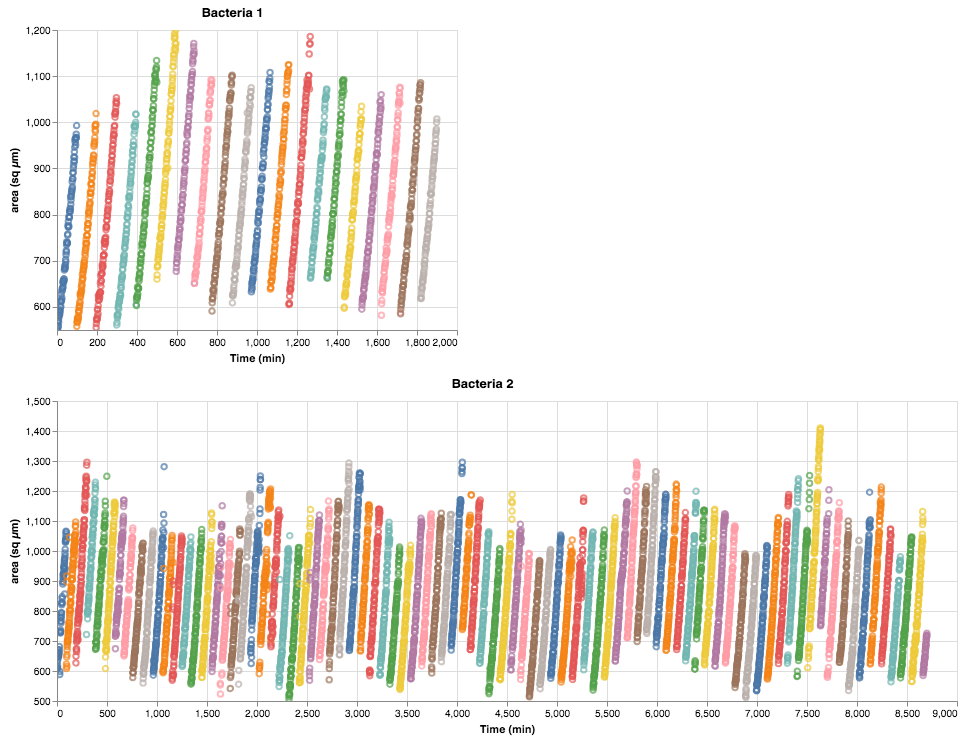

In [15]:
plot1 = alt.Chart(bac1_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
            tooltip = ["label", "isDivision", 'area (sq µm)']
        ).interactive().properties(title = "Bacteria 1")

plot2 = alt.Chart(bac2_thresh).mark_point().encode(
            x=alt.X('label', title = "Time (min)"),
            y=alt.Y('area (sq µm)', scale=alt.Scale(zero=False)),
            color = alt.Color('div_num:N',legend=None),
            tooltip = ["label", "isDivision", 'area (sq µm)', 'div_num']
        ).interactive().properties(height=300,
                                   width=900,
                                   title = "Bacteria 2")
plot1 & plot2

Yay! Now the data looks ready for modeling! The format we want in order to send this into Stan is a little tricky. Stan only wants arrays of a fixed length, so we will need separate arrays that specify:
1. The cell area
2. The time the cell has been growing in minutes since the last division
3. The cell
4. The division number for that cell

Each of these arrays must be the length of our entire data set. I will set about making these from the above data. 

In [16]:
bac1_thresh.loc[:,"bac_id"] = np.zeros(len(bac1_thresh.index))
bac2_thresh.loc[:,"bac_id"] = np.ones(len(bac2_thresh.index))
# Concatenate this into a single dataframe
data = pd.concat([bac1_thresh, bac2_thresh])
data = data.rename(columns = {"label":"time (min)"})
data = data.drop(columns = ["isDivision"])

/home/ec2-user/miniconda/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


The time column is currently a disaster. We need to isolate each series and then subtract the start time of the series from all time points in the series. I will write a function to find the min, and then calculate the min for every point in the dataframe. This is a slow way to do this, but it's easy to think about and possible since we don't have hundreds of thousands of data points. 

In [17]:
def find_min_time(data, index):
    """Finds the min time in the dataframe data for the series 
    associated with the entry at index 'index'. """
    bac_num = data["bac_id"].values[index]
    div_num = data["div_num"].values[index]
    series = data[data["bac_id"]==bac_num]
    series = series[series["div_num"]==div_num]
    series_times = series["time (min)"].values
    return np.min(series_times)
times = data["time (min)"].values
new_times = np.zeros(len(data.index))
for i in range(0, len(new_times)):
    new_times[i] = times[i] - find_min_time(data.copy(), i)
data["time (min)"] = new_times

Let's sanity-check the non-trivial operation that I just did by making a few plots. 

In [18]:
plots = [0]*4
# Series to plot were chosen arbitrarily
for i in range(0, 4):
    data_plot = data[data["bac_id"] == (i % 2)]
    data_plot = data_plot[data_plot["div_num"] == i * 2 + 1]
    time = data_plot["time (min)"].values
    area = data_plot['area (sq µm)'].values
    p = bokeh.plotting.Figure(height=300, width=200, 
                              title = "Bacteria %i Division %i" % (i % 2, i * 2 + 1),
                              x_axis_label = "time (min)",
                              y_axis_label = "cell area (sq µm)")
    p.circle(time, area)
    plots[i] = p
bokeh.io.show(bokeh.layouts.row(plots))
data.head()

,time (min),area (sq µm),div_num,bac_id
2,0.0,551,0.0,0.0
3,1.0,568,0.0,0.0
4,2.0,554,0.0,0.0
5,3.0,559,0.0,0.0
6,4.0,558,0.0,0.0


Yay!! All our data is plotted on a time axis that makes intuitive sense! The last wrangling I want to do is to make the division number more informative. It would be best if it were unique across the entire dataframe, and also if it started at one. This way, it can be used for indexing in stan. 

In [19]:
# I'll make bac_id 1 and 2 for stan indexing also
data.loc[:,"bac_id"] = data["bac_id"].values + 1
# make div_num unique

bac_id = data["bac_id"].values
max_div_num = np.max(data[data["bac_id"]==1]["div_num"].values)
div_num = data["div_num"].values
for i in range(0, len(div_num)):
    if bac_id[i] == 2:
        div_num[i] = div_num[i] + max_div_num + 1
div_num = div_num + 1
data.loc[:,"div_num"] = div_num
data.head()

,time (min),area (sq µm),div_num,bac_id
2,0.0,551,1.0,1.0
3,1.0,568,1.0,1.0
4,2.0,554,1.0,1.0
5,3.0,559,1.0,1.0
6,4.0,558,1.0,1.0


This dataframe is valuable, and I want to be able to access it from external python files, which will be able to run MCMC faster than a jupyter kernel. I'll save it to a CSV, and then reload it for consistency. 

In [20]:
data.to_csv("./9.1_data_wrangled.csv")

Our dataframe is in a format such that stan will be able to interpret the columns. We may now focus on the stan model!

# Deriving the Hierarchical Stan Models
## Exponential Model

Our hierarchical model will have 3 layers:
0. Parameters that describe general cell growth.
1. Parameters that describe the growth of each cell.
2. Parameters that describe each growing period of a paricular cell. 

I will first focus on the exponential model, which states:
$$\text{Cell mass ~ Cell Area } = a_0e^{kt}$$

The image processing gave us error that can be erratic, so error at the lower levels of the model would probaby not be best modeled as guassian. The Student-t distribution is a better choice in this case, and we will parametrize the distribution differently for each cell. Using this model and plugging in the exponential as the peak of the Student-t, our model predicts:
$$\text{Cell Area ~ student_t}(\nu_{2,i}, (a_0)_{2, n, i}e^{k_{2, n, i}t}, \sigma_{2,i})$$

where subscripts are of the form: $\nu_{\text{model layer}, \text{ cell number}}$ and $(a_0)_{\text{model layer}, \text{ growth event}, \text{ cell number}}$ ($n$ is growth event, $i$ is cell number).
We can immeditely come up with priors on $\nu$ and $\sigma$. The heaviness of the tails can vary a lot, so I'll choose a broad prior on $\nu$, 
$$ \nu_{2, i} \sim 1 + 10 * \text{lognormal}(0.1, 1.0)$$
The measurement error might vary by about 20 µm$^2$, so I'll make sigma half-normal with a standard deviation of 20. 
$$ \sigma_{2, i} \sim 20 * \text{halfnormal}(0, 1)$$

The rest of the hierarchy will be less complicated. The parameters for the individual growth events will be drawn from the distributions above in the following way:

$a_0$ from the bottom layer is found from the $a_0$ above it, with some deviation:

\begin{align}
(a_0)_{2, n, i} \sim & \, \text{norm}((a_0)_{1, i}, \sigma_{a, 1, i})\\
\sigma_{a, 1, i} \sim & \, 100 * \text{halfnorm}(0, 1)
\end{align}

$k$ is similar. 

\begin{align}
k_{2, n, i} \sim & \, k_{1, i} + \sigma_{k, 1, i} * \text{norm}(0, 1)\\
\sigma_{k, 1, i} \sim & \, 0.001 * \text{halfnorm(0, 1)}
\end{align}

We repeat this process to derive the mid-layer hyperparameters. 

\begin{align}
(a_0)_{1, i} \sim & \,(a_0)_{0} + \sigma_{a, 0} * \text{norm}(0, 1)\\
\sigma_{a, 0} \sim & \, 50 * \text{halfnorm}(0, 1)\\
k_{1, i} \sim & \, k_{0} + \sigma_{k, 0} * \text{norm}(0, 1)\\
\sigma_{k, 0} \sim & \, 0.005 * \text{halfnorm(0, 1)}
\end{align}

Finally, we use simple positive priors for the hyperparameters. Note that log-normal was chosen for $k$ because it must be positive but may be small, and $a_0$ was chosen by approximating the initial cell area as around 600 µm$^2$.

\begin{align}
k_{0} \sim & \, \text{lognorm}(-4.5, 0.4)\\
(a_0)_0 \sim & \, \text{norm(600, 100)}
\end{align}

## Linear model
The linear model will be the same as the exponential model, with some small changes. 

CONTINUED

# Prior Predictive Check

## Exponential model

First, I will compile and print out the model:

In [21]:
ppc_exp = bebi103.stan.StanModel(file='./9.1_prior_pred_exp.stan')
print(ppc_exp.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_058c2045769f35c1dfec715a08af3634 NOW.
/home/ec2-user/miniconda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpubz7qtkw/stanfit4anon_model_058c2045769f35c1dfec715a08af3634_1966427152357290089.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


data
{
    int N; // number of total data points combined
    int num_divisions; // number of growth events
    int num_cells; // number of cells measured
    int div_num[N]; // Denotes growth period per data point
    int bac_id_per_div_num[num_divisions]; // bac_id per division number
    int bac_id[N]; // The bacterium being studied at each data point
    real time[N]; // Time elapsed since last division
}

generated quantities
{
    // PPC output
    vector[N] areas; // cell area over time
    vector[N] model_pred; // expected value for cell area

    // bottom layer parameters
    vector<lower=0>[num_divisions] a0_2; // bottom layer growth coefficient 
    vector[num_divisions] k_2;  // bottom layer growth rate
    vector<lower=0>[num_cells] sigma_2; // variation in area measurement (unique per cell)
    vector<lower=1>[num_cells] nu_2;  // tail-weight in area measurement (unique per cell)

    // mid-layer parameters
    vector[num_cells] a0_1; // mid-layer growth coefficient
   

I will be running sampling code externally in python, so I'm reloading the dataframe to be consistent with external python files I will write. 

In [22]:
data = pd.read_csv("./9.1_data_wrangled.csv")
data = data.drop(columns = ["Unnamed: 0"])
data.head()

,time (min),area (sq µm),div_num,bac_id
0,0.0,551,1.0,1.0
1,1.0,568,1.0,1.0
2,2.0,554,1.0,1.0
3,3.0,559,1.0,1.0
4,4.0,558,1.0,1.0


I need to do one last bit of wrangling in order to synthesize the arrays that stan needs. This is mostly just getting the bacteria number as an array in terms of the division occuring. 

In [23]:
# let's just see how many divisions we have in total. 
# We will need to feed this parameter into stan
N = len(div_num)
num_divisions = len(np.unique(div_num))

# I need to make an array that specifies the bacterium for each division
unique_div_nums = np.unique(div_num)
bac_id_per_div_num = np.zeros(len(unique_div_nums))
for i in range(0, len(unique_div_nums)):
    div = unique_div_nums[i]
    sub_df = data[data["div_num"]==div]
    bac_id_per_div_num[i] = sub_df.iloc[0]["bac_id"]
print("Bacteria ID for each division number:")
print(bac_id_per_div_num)

Bacteria ID for each division number:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


Now I will set up the input dictionary, which will be simple given the previous data wrangling, and then perform sampling for the prior predictive check. 

In [28]:
ppc_exp_samples = None
try:
    ppc_exp_samples, ppc_exp = bebi103.stan.pickle_load_samples("./9.1_ppc_exp.pkl")
except (FileNotFoundError, ModuleNotFoundError):
    ppc_dict = {"N":N,
            "num_divisions": num_divisions,
            "num_cells": 2,
            "div_num": data["div_num"].values.astype(int),
            "bac_id_per_div_num": bac_id_per_div_num.astype(int),
            "bac_id": data["bac_id"].values.astype(int),
            "time": data["time (min)"].values}

    ppc_exp_samples = ppc_exp.sampling(data=ppc_dict,
                                   algorithm='Fixed_param',
                                   warmup=0,
                                   chains=1,
                                   iter=100)
    bebi103.stan.pickle_dump_samples(fit = ppc_exp_samples,
                                     model = ppc_exp,
                                     pkl_file = "./9.1_ppc_exp.pkl")

/home/ec2-user/miniconda/lib/python3.7/site-packages/bebi103/stan.py:297: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model': model, 'fit': fit}, f, protocol=-1)


Sampling is complete! Now I am transitioning back into the sort of code that I will always run in jupyter, so I will load in the pickled file (depite that it already exists), and load it as a dataframe. 

In [29]:
df_ppc_exp = bebi103.stan.to_dataframe(ppc_exp_samples, inc_warmup = False, diagnostics=False)
df_ppc_exp.head()

,chain,chain_idx,warmup,areas[1],areas[2],areas[3],areas[4],areas[5],areas[6],areas[7],...,sigma_a_1[2],k_1[1],k_1[2],sigma_k_1[1],sigma_k_1[2],a0,k,sigma_a_0,sigma_k_0,lp__
0,1,1,0,428.137046,412.796441,381.406978,408.766376,439.974023,400.279445,427.125625,...,72.517607,0.011682,0.010027,0.000336,0.001550,622.000468,0.010361,19.233269,0.000897,0.0
1,1,2,0,530.862476,516.389593,525.254362,540.410278,543.089693,547.419848,595.010803,...,37.826776,0.008661,0.010797,0.000734,0.000963,557.076377,0.012104,62.291133,0.003446,0.0
2,1,3,0,543.930270,534.877999,551.693672,547.354229,576.599352,604.576428,593.535606,...,52.143043,0.012268,0.013811,0.000175,0.001025,679.116645,0.014844,19.109979,0.008843,0.0
3,1,4,0,255.941063,237.902599,251.414178,260.342203,258.414723,264.894042,273.438462,...,113.740439,0.019097,0.019399,0.002069,0.001126,507.507986,0.019395,67.059493,0.000423,0.0
4,1,5,0,581.752278,578.058526,624.708427,590.070603,624.452380,640.408315,615.789863,...,162.057580,0.011125,0.011240,0.000320,0.000767,584.054827,0.010132,15.007049,0.003460,0.0


Sampling worked! Let's see how the model performed by plotting the first series.

In [30]:
# I will start by plotting the first series
num_pts = len(data[data["div_num"]==1]["div_num"].values)
df_ppc_exp_plot = df_ppc_exp.dropna()
df_ppc_exp_plot = df_ppc_exp_plot[["areas[%i]"%i for i in range(1, num_pts + 1)]]
time = data[data["div_num"]==1]["time (min)"].values
p = bokeh.plotting.Figure(height = 500, 
                          width = 600, 
                          title = "Series 1 Prior Predicitve Check",
                          y_range = [300, 1500],
                          x_axis_label = "time (min)",
                          y_axis_label = "Cell area")
for i in range(0, len(df_ppc_exp_plot.index)):
    p.line(time, df_ppc_exp_plot.iloc[i].values, line_width = 0.2)
bokeh.io.show(p)

This PPC is awesome. It is like a laser of chaotic awesomeness. 

In [31]:
%load_ext watermark
%watermark -v -p numpy,pandas,pystan,bokeh,altair,bebi103,jupyterlab

CPython 3.7.0
IPython 7.0.1

numpy 1.15.2
pandas 0.23.4
pystan 2.18.0.0
bokeh 0.13.0
altair 2.2.2
bebi103 0.0.40
jupyterlab 0.35.1


# Miscellaneous Shit I might want later

/home/ec2-user/miniconda/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/ec2-user/miniconda/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


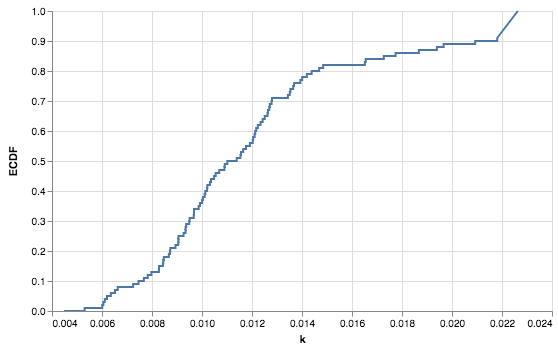

In [32]:
altcat.catplot(data=df_ppc_exp,
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x=alt.X('k:Q')),
               transform='ecdf')

In [104]:
ppc_lin = bebi103.stan.StanModel(file='./9.1_prior_pred_lin.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c098fd5f6c52c752519167ed5b9dd1e6 NOW.
/home/ec2-user/miniconda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpgn4bchge/stanfit4anon_model_c098fd5f6c52c752519167ed5b9dd1e6_2639372788387941182.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [105]:
ppc_dict = {"N":N,
            "num_divisions": num_divisions,
            "num_cells": 2,
            "div_num": data["div_num"].values.astype(int),
            "bac_id_per_div_num": bac_id_per_div_num.astype(int),
            "bac_id": data["bac_id"].values.astype(int),
            "time": data["time (min)"].values}

ppc_lin_samples = ppc_lin.sampling(data=ppc_dict,
                                   algorithm='Fixed_param',
                                   warmup=0,
                                   chains=1,
                                   iter=100)

In [106]:
df_ppc_lin = bebi103.stan.to_dataframe(ppc_lin_samples, inc_warmup = False, diagnostics=False)
df_ppc_lin.head()

,chain,chain_idx,warmup,areas[1],areas[2],areas[3],areas[4],areas[5],areas[6],areas[7],...,sigma_a_1[2],b_1[1],b_1[2],sigma_b_1[1],sigma_b_1[2],a0,b,sigma_a_0,sigma_b_0,lp__
0,1,1,0,719.862360,739.196190,742.575746,764.269201,751.102882,782.682214,789.018546,...,0.043630,9.484354,9.441996,0.000537,0.000166,752.959046,9.372659,11.178353,0.079575,0.0
1,1,2,0,499.698484,484.914822,453.928898,419.797007,465.558704,486.605935,469.577141,...,0.065622,5.362685,5.238062,0.000166,0.000445,489.143185,5.265992,66.816885,0.055255,0.0
2,1,3,0,516.106522,571.929835,543.033043,519.399132,546.741145,558.906362,572.517538,...,0.135121,6.039308,6.773894,0.000155,0.000037,528.707125,6.154409,21.174670,0.415559,0.0
3,1,4,0,546.021639,611.876562,648.950019,621.668953,615.586518,659.550248,673.287946,...,0.822589,7.689902,7.695567,0.000319,0.000191,582.586606,7.451150,8.023936,0.239274,0.0
4,1,5,0,634.061872,676.737038,623.775446,661.136153,673.164410,660.919120,625.524000,...,0.123973,11.006042,10.975563,0.000662,0.000060,656.867497,10.961705,27.345982,0.021212,0.0


In [107]:
len(df_ppc_lin) - len(df_ppc_lin.dropna())

0

In [108]:
df_ppc_lin.head(10)

,chain,chain_idx,warmup,areas[1],areas[2],areas[3],areas[4],areas[5],areas[6],areas[7],...,sigma_a_1[2],b_1[1],b_1[2],sigma_b_1[1],sigma_b_1[2],a0,b,sigma_a_0,sigma_b_0,lp__
0,1,1,0,719.862360,739.196190,742.575746,764.269201,751.102882,782.682214,789.018546,...,0.043630,9.484354,9.441996,0.000537,0.000166,752.959046,9.372659,11.178353,0.079575,0.0
1,1,2,0,499.698484,484.914822,453.928898,419.797007,465.558704,486.605935,469.577141,...,0.065622,5.362685,5.238062,0.000166,0.000445,489.143185,5.265992,66.816885,0.055255,0.0
2,1,3,0,516.106522,571.929835,543.033043,519.399132,546.741145,558.906362,572.517538,...,0.135121,6.039308,6.773894,0.000155,0.000037,528.707125,6.154409,21.174670,0.415559,0.0
3,1,4,0,546.021639,611.876562,648.950019,621.668953,615.586518,659.550248,673.287946,...,0.822589,7.689902,7.695567,0.000319,0.000191,582.586606,7.451150,8.023936,0.239274,0.0
4,1,5,0,634.061872,676.737038,623.775446,661.136153,673.164410,660.919120,625.524000,...,0.123973,11.006042,10.975563,0.000662,0.000060,656.867497,10.961705,27.345982,0.021212,0.0
5,1,6,0,541.301808,540.219185,543.049328,615.511859,567.781365,555.978617,538.025835,...,0.287711,5.409262,5.223517,0.000090,0.000563,518.025325,4.929731,29.882298,0.636402,0.0
6,1,7,0,727.984150,658.083590,723.943873,693.360507,725.666766,698.605427,772.892721,...,0.071686,4.758253,4.744854,0.000264,0.000775,732.852965,4.761467,37.775172,0.016703,0.0
7,1,8,0,676.587831,683.505858,710.909593,690.926231,694.135192,719.594039,701.739466,...,0.861696,3.753005,3.766146,0.000279,0.000679,700.323153,3.729820,32.012374,0.085903,0.0
8,1,9,0,615.894116,600.303247,589.887456,673.913647,636.523604,622.594360,599.238122,...,0.435720,3.987267,4.437322,0.000053,0.000119,605.050155,4.911711,22.240345,0.707117,0.0
9,1,10,0,679.768627,645.461447,640.856430,641.266710,675.042992,631.064093,644.574500,...,0.712349,3.501808,3.542563,0.000414,0.000818,654.817632,3.194542,18.169896,0.356788,0.0


In [109]:
# I will start by plotting the first series
num_pts = len(data[data["div_num"]==1]["div_num"].values)
df_ppc_lin_plot = df_ppc_lin.dropna()
df_ppc_lin_plot = df_ppc_lin_plot[["areas[%i]"%i for i in range(1, num_pts + 1)]]
time = data[data["div_num"]==1]["time (min)"].values
p = bokeh.plotting.Figure(height = 500, 
                          width = 600, 
                          title = "Series 2 Prior Predicitve Check",
                          y_range = [300, 1500],
                          x_axis_label = "time (min)",
                          y_axis_label = "Cell area")
for i in range(0, len(df_ppc_lin_plot.index)):
    p.line(time, df_ppc_lin_plot.iloc[i].values, line_width = 0.2)
bokeh.io.show(p)

In [128]:
ppc_lin = bebi103.stan.StanModel(file='./9.1_mcmc_lin.stan')

ValueError: Failed to parse Stan model 'anon_model_8adfe2dded26d1f79a57f877d1b7b00d'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

No matches for: 

  vector * vector

Available argument signatures for operator*:

  real * real
  vector * real
  row vector * real
  matrix * real
  row vector * vector
  vector * row vector
  matrix * vector
  row vector * matrix
  matrix * matrix
  real * vector
  real * row vector
  real * matrix

No matches for: 

  vector + ill formed

Available argument signatures for operator+:

  int + int
  real + real
  vector + vector
  row vector + row vector
  matrix + matrix
  vector + real
  row vector + real
  matrix + real
  real + vector
  real + row vector
  real + matrix
  +int
  +real
  +vector
  +row vector
  +matrix

Expression is ill formed
  error in 'unknown file name' at line 61, column 29
  -------------------------------------------------
    59:      vector[num_divisions] a0_2 = a0_1[bac_id_per_div_num] 
    60:                   + sigma_a_1[bac_id_per_div_num] 
    61:                   * a0_1_til;
                                    ^
    62:      vector[num_divisions] b_2 = b_1[bac_id_per_div_num] 
  -------------------------------------------------

